In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import matplotlib.pyplot as plt


In [21]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
paths = [
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2021_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2022_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2023_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2024_yearly_15min.parquet"
]


In [23]:
dfs = []
for p in paths:
    dfp = pd.read_parquet(p, engine="pyarrow")
    dfp = dfp.rename(columns={
        "time_bucket":"ds",
        "start_station_id":"station_id",
        "booking_count":"y"
    })
    dfp["ds"] = pd.to_datetime(dfp["ds"])
    dfp["station_id"] = dfp["station_id"].astype(str)
    dfs.append(dfp)
rides_df = pd.concat(dfs, ignore_index=True)


In [24]:
# 2. Filter for your station
station_id = "4818.03"
rides_df = rides_df[rides_df["station_id"] == station_id].copy()


In [25]:
# 3. Load & prepare static urban features
urban_df = pd.read_csv("C:/Users/mahar/Downloads/Final_Urban_Feaatures_Merged_csv.csv", header=1)
urban_df["station_id"] = urban_df["station_id"].astype(str)
uf = (urban_df
      .set_index("station_id")
      .loc[station_id]
      .drop("station_id", errors="ignore")
      .to_dict())

In [26]:
 #4. Load weather
weather_df = (
    pd.read_csv(
        r"C:/Users/mahar/Downloads/Capstone for Models/final_weather_dataset (1) (1).csv",
        parse_dates=["DATE"]
    )
    .rename(columns={"DATE":"ds"})
)

In [27]:
# 5. Merge everything
df = (
    rides_df
      .merge(weather_df, on="ds", how="left")
      .assign(**uf)
      .sort_values("ds")
      .reset_index(drop=True)
)

In [28]:
# 6. Fill missing & one-hot
df.ffill(inplace=True)
df.bfill(inplace=True)
df.fillna(0, inplace=True)
cat_cols = df.select_dtypes(["object","category"]).columns.difference(["station_id","ds"])
if len(cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)


In [29]:
# 7. Aggregate to **daily** frequency
#    - sum 'y'
#    - take first() for covariates
df.set_index("ds", inplace=True)
cov_cols = df.columns.difference(["station_id","y"])
agg_dict = {"y":"sum", **{c:"first" for c in cov_cols}}
df_daily = df.resample("D").agg(agg_dict).dropna().reset_index()


In [30]:
# 8. Prepare arrays & scale
dates      = df_daily["ds"].values
y_raw      = df_daily["y"].values.reshape(-1,1)
cov_raw    = df_daily.drop(columns=["ds","y"], errors="ignore").values

y_scaler   = StandardScaler();    target     = y_scaler.fit_transform(y_raw)
cov_scaler = StandardScaler();    covariates = cov_scaler.fit_transform(cov_raw)


In [31]:
# 9. Split 70/15/15
n = len(target)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_y, val_y, test_y = (target[:train_end],
                          target[train_end:val_end],
                          target[val_end:])
train_c, val_c, test_c = (covariates[:train_end],
                          covariates[train_end:val_end],
                          covariates[val_end:])


In [32]:
# 10. Sequence Dataset & DataLoader
context, horizon, batch_size = 30, 1, 32

class SeqDataset(Dataset):
    def __init__(self,y,c,ctx,h):
        self.y, self.c, self.ctx, self.h = y, c, ctx, h
    def __len__(self):
        return len(self.y) - (self.ctx + self.h) + 1
    def __getitem__(self, i):
        sy = self.y[i : i+self.ctx+self.h]
        sc = self.c[i : i+self.ctx+self.h]
        x_enc = np.concatenate([sy[:self.ctx].reshape(-1,1), sc[:self.ctx]], axis=1)
        y_true = sy[self.ctx:].ravel()
        return (torch.tensor(x_enc, dtype=torch.float32),
                torch.tensor(y_true, dtype=torch.float32))

train_dl = DataLoader(SeqDataset(train_y, train_c, context, horizon),
                      batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(SeqDataset(val_y,   val_c,   context, horizon),
                      batch_size=batch_size)
test_ds  = SeqDataset(test_y, test_c, context, horizon)


In [33]:
# 11. Define GRU Model
input_size  = 1 + covariates.shape[1]
hidden_size, num_layers = 64, 2

class GRUForecast(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc  = nn.Linear(hidden_size, horizon)
    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

model   = GRUForecast().to(device)
opt     = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [34]:
# 12. Training Loop
for epoch in range(1, 21):
    model.train(); tr_losses = []
    for x_enc, y_t in train_dl:
        x_enc, y_t = x_enc.to(device), y_t.to(device)
        opt.zero_grad()
        loss = loss_fn(model(x_enc), y_t)
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())
    model.eval(); vl_losses = []
    with torch.no_grad():
        for x_enc, y_t in val_dl:
            x_enc, y_t = x_enc.to(device), y_t.to(device)
            vl_losses.append(loss_fn(model(x_enc), y_t).item())
    print(f"Epoch {epoch:02d} ▶ tr_loss: {np.mean(tr_losses):.4f} — val_loss: {np.mean(vl_losses):.4f}")


Epoch 01 ▶ tr_loss: 0.7513 — val_loss: 0.5575
Epoch 02 ▶ tr_loss: 0.6064 — val_loss: 0.5436
Epoch 03 ▶ tr_loss: 0.5845 — val_loss: 0.5486
Epoch 04 ▶ tr_loss: 0.5768 — val_loss: 0.5401
Epoch 05 ▶ tr_loss: 0.5788 — val_loss: 0.5390
Epoch 06 ▶ tr_loss: 0.5684 — val_loss: 0.5285
Epoch 07 ▶ tr_loss: 0.5597 — val_loss: 0.5220
Epoch 08 ▶ tr_loss: 0.5423 — val_loss: 0.5202
Epoch 09 ▶ tr_loss: 0.5726 — val_loss: 0.5187
Epoch 10 ▶ tr_loss: 0.5450 — val_loss: 0.5134
Epoch 11 ▶ tr_loss: 0.5417 — val_loss: 0.5199
Epoch 12 ▶ tr_loss: 0.5333 — val_loss: 0.5262
Epoch 13 ▶ tr_loss: 0.5335 — val_loss: 0.5161
Epoch 14 ▶ tr_loss: 0.5232 — val_loss: 0.5313
Epoch 15 ▶ tr_loss: 0.5338 — val_loss: 0.5295
Epoch 16 ▶ tr_loss: 0.5099 — val_loss: 0.5283
Epoch 17 ▶ tr_loss: 0.5227 — val_loss: 0.5195
Epoch 18 ▶ tr_loss: 0.5144 — val_loss: 0.5206
Epoch 19 ▶ tr_loss: 0.5158 — val_loss: 0.5292
Epoch 20 ▶ tr_loss: 0.5084 — val_loss: 0.5255


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# === 13. 90‑Day Roll‑Forward Forecast, Metrics & Plot ===
look_ahead = 90

# 1) Roll‑forward forecast
ctx_seq    = np.concatenate([
    target[-context:].reshape(-1,1),
    covariates[-context:]
], axis=1)
future_cov = covariates[-look_ahead:]
future_preds = []

model.eval()
with torch.no_grad():
    for t in range(look_ahead):
        inp = torch.tensor(ctx_seq[-context:], dtype=torch.float32) \
                   .unsqueeze(0).to(device)
        out = model(inp).cpu().numpy().ravel()[0]
        future_preds.append(out)
        ctx_seq = np.vstack([ctx_seq, np.concatenate([[out], future_cov[t]])])

future_vals = y_scaler.inverse_transform(
    np.array(future_preds).reshape(-1,1)
).ravel()

# 2) Test‑set evaluation
test_preds, test_trues = [], []
with torch.no_grad():
    for i in range(len(test_ds)):
        x_enc, y_true = test_ds[i]
        p = model(x_enc.unsqueeze(0).to(device)).cpu().numpy().ravel()[0]
        test_preds.append(p)
        test_trues.append(y_true.item())

true_test = y_scaler.inverse_transform(
    np.array(test_trues).reshape(-1,1)
).ravel()
pred_test = y_scaler.inverse_transform(
    np.array(test_preds).reshape(-1,1)
).ravel()

mae  = mean_absolute_error(true_test, pred_test)
mse  = mean_squared_error(true_test, pred_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(true_test, pred_test) * 100

print("Test Metrics (daily):")
print(f" MAE  = {mae:.3f}")
print(f" MSE  = {mse:.3f}")
print(f" RMSE = {rmse:.3f}")
print(f" MAPE = {mape:.2f}%\n")

Test Metrics (daily):
 MAE  = 5.400
 MSE  = 48.500
 RMSE = 6.964
 MAPE = 28.54%



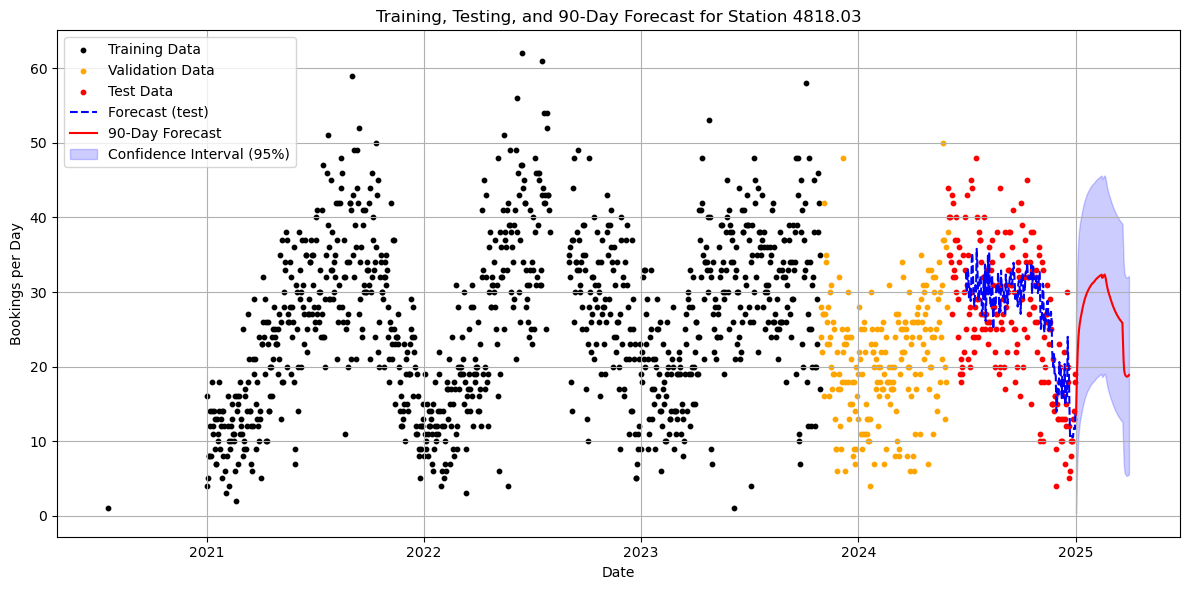

In [46]:
# 3) Build date & value arrays
dates_all       = pd.to_datetime(df_daily["ds"])
train_dates     = dates_all[:train_end]
val_dates       = dates_all[train_end:val_end]
test_dates      = dates_all[val_end:]
test_pred_dates = dates_all[val_end + context : val_end + context + len(test_preds)]
future_dates    = pd.date_range(
    dates_all.iloc[-1] + pd.Timedelta(days=1),
    periods=look_ahead
)

train_vals = y_scaler.inverse_transform(target[:train_end]).ravel()
val_vals   = y_scaler.inverse_transform(target[train_end:val_end]).ravel()
test_vals  = y_scaler.inverse_transform(target[val_end:]).ravel()

sigma = np.std(true_test - pred_test)

# 4) Plot everything
plt.figure(figsize=(12,6))

# scatter segments
plt.scatter(train_dates, train_vals, s=10, color='black', label='Training Data')
plt.scatter(val_dates,   val_vals,   s=10, color='orange', label='Validation Data')
plt.scatter(test_dates,  test_vals,  s=10, color='red',    label='Test Data')

# dashed blue: model vs. test
plt.plot(test_pred_dates, pred_test, '--', color='blue', label='Forecast (test)')

# solid red: 90‑day forecast
plt.plot(future_dates, future_vals, '-', color='red', label=f'{look_ahead}-Day Forecast')

# 95% CI shading
ci_lower = future_vals - 1.96 * sigma
ci_upper = future_vals + 1.96 * sigma
plt.fill_between(future_dates, ci_lower, ci_upper,
                 color='blue', alpha=0.2, label='Confidence Interval (95%)')

plt.title(f"Training, Testing, and 90‑Day Forecast for Station {station_id}")
plt.xlabel("Date")
plt.ylabel("Bookings per Day")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

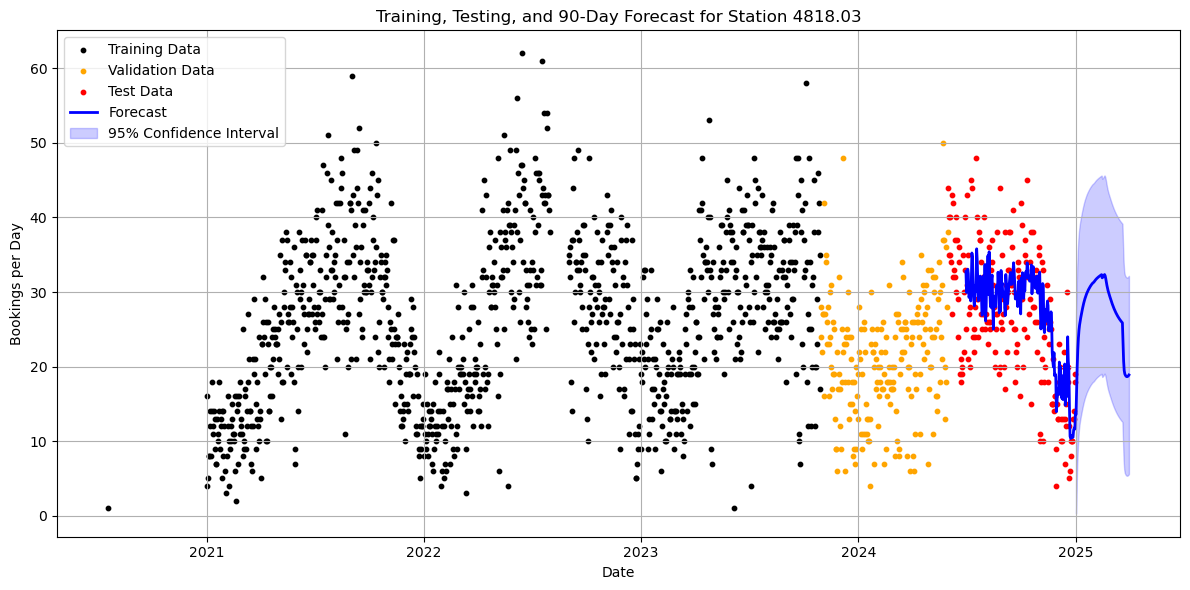

In [48]:
# 1) Build the unified prediction series
pred_dates = np.concatenate([test_pred_dates, future_dates])
pred_vals  = np.concatenate([pred_test,    future_vals])

# 2) Plot
plt.figure(figsize=(12,6))

# scatter train/val/test
plt.scatter(train_dates, train_vals, s=10, color='black', label='Training Data')
plt.scatter(val_dates,   val_vals,   s=10, color='orange', label='Validation Data')
plt.scatter(test_dates,  test_vals,  s=10, color='red',    label='Test Data')

# continuous forecast line
plt.plot(pred_dates, pred_vals, '-', color='blue', linewidth=2, label='Forecast')

# only shade future CI
ci_lower = future_vals - 1.96 * sigma
ci_upper = future_vals + 1.96 * sigma
plt.fill_between(future_dates, ci_lower, ci_upper,
                 color='blue', alpha=0.2, label='95% Confidence Interval')

# styling
plt.title(f"Training, Testing, and 90‑Day Forecast for Station {station_id}")
plt.xlabel("Date")
plt.ylabel("Bookings per Day")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Print raw test‐set predictions
print("Test‐set predictions (bookings per day):")
print(pred_test)


Test‐set predictions (bookings per day):
[32.738472 29.954943 30.067656 33.067722 32.44958  29.276249 29.475864
 30.494226 28.79699  31.299755 35.232334 34.676136 31.681953 29.290337
 28.136864 29.269966 30.924412 30.078697 35.79068  34.171864 31.029642
 28.83001  29.55813  31.737959 32.13336  31.553885 29.700487 26.875387
 27.0071   29.519152 32.203426 28.993006 33.691845 26.113619 27.962294
 32.61092  31.82559  34.878784 29.687496 35.385395 30.49245  28.43626
 27.944944 31.718994 32.270954 28.773302 25.013649 28.81087  29.44682
 28.211878 28.02478  30.802734 30.30874  30.177345 32.655384 30.8345
 27.18641  28.861483 27.416111 32.888046 30.833647 31.20673  29.565187
 29.301971 29.983301 28.3282   26.83471  32.34954  31.01978  30.528301
 28.401354 29.472683 30.811073 31.235336 32.205147 32.60418  31.0148
 31.021355 31.346716 32.568783 33.920452 32.80853  31.226757 29.06265
 29.821302 29.44743  29.321783 28.043716 31.055061 31.491646 30.768854
 30.012194 27.062635 31.875023 31.368258 32

In [50]:
import pandas as pd

df_preds = pd.DataFrame({
    "ds": test_pred_dates,
    "predicted_y": pred_test
})
print(df_preds)


             ds  predicted_y
1243 2024-06-30    32.738472
1244 2024-07-01    29.954943
1245 2024-07-02    30.067656
1246 2024-07-03    33.067722
1247 2024-07-04    32.449581
...         ...          ...
1423 2024-12-27    10.520792
1424 2024-12-28    11.487737
1425 2024-12-29    11.775564
1426 2024-12-30    11.610538
1427 2024-12-31    13.857148

[185 rows x 2 columns]


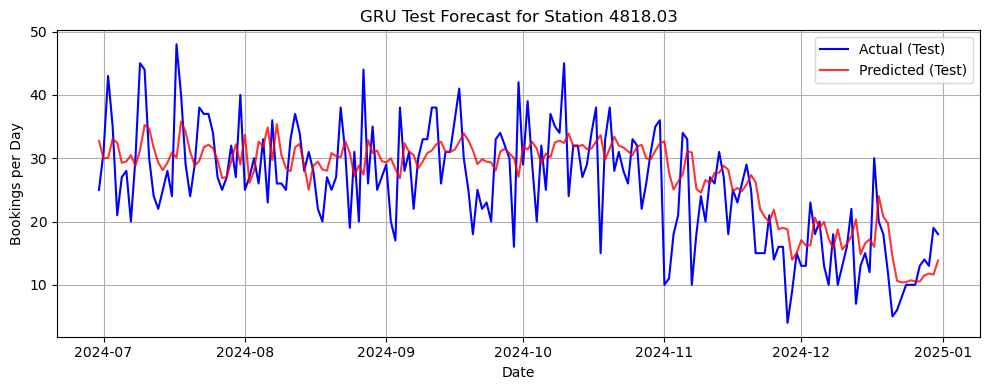

In [52]:
# 9. Plot Actual vs Predicted
test_dates = dates[val_end + context:]
plt.figure(figsize=(10,4))
plt.plot(test_dates, true_test, label="Actual (Test)", color="blue")
plt.plot(test_dates, pred_test, label="Predicted (Test)", color="red", alpha=0.8)
plt.title(f"GRU Test Forecast for Station {station_id}")
plt.xlabel("Date"); plt.ylabel("Bookings per Day")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()